# Amazon Bin Image Dataset EDA

In this notebook, an exploratory EDA of the Amazon Bin Image Dataset is performed.

Information on the dataset can be found at: https://github.com/awslabs/open-data-docs/tree/main/docs/aft-vbi-pds.

In short, the dataset contains 500,000 bin JPEG images and corresponding JSON metadata files describing items. There is a JSON file for each image.

The images are snapshots of the contents of bins within Amazon distribution centers. Each bin contains a certain number of items. The JSON metadata file for each image contains information about the products in the bin, and the count of the number of items. 

Due to the large size of the dataset, to the cost/time constraints for this project, a randomly selected subsample of 50,000 images will be extracted from the full dataset.

The goal of this EDA is to characterize the subsample, create labels for machine learning, and perform a train, validation, test split.

## Setup S3 bucket with the images

NOTE: transfer from public bin to private S3 for the full dataset requires several hours. Run only once!

In [ ]:
import boto3

client = boto3.client('s3')
response = client.create_bucket(
    ACL='private',
    Bucket='amazon-bin-images',
)

In [ ]:
# Copy images to S3
!aws s3 sync s3://aft-vbi-pds/bin-images/ s3://amazon-bin-images/

In [ ]:
# Copy metadata to S3
!aws s3 sync s3://aft-vbi-pds/metadata/ s3://amazon-bin-images/

## Import useful module for the rest of the analysis

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
from eda_utils import *
import boto3

import matplotlib as mpl
from matplotlib import pyplot as plt

## Extract a random subsample of 50,000 images from the first 500,000 images

This piece of code runs only locally and only operates on the ids.

In [2]:
image_ids_sel_path = './image_ids_sel.csv'
n_full = 500000
n_sel = 50000
if not os.path.exists(image_ids_sel_path):
    image_ids_sel = generate_image_ids_sel(image_ids_sel_path,n_full,n_sel)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_path)

Loaded random subsample of 50000 images.


In [3]:
image_ids_sel

,id
0,1
1,14
2,17
3,30
4,31
...,...
49995,499920
49996,499932
49997,499938
49998,499978


## Load labels from metadata on S3

This piece of code accesses the JSON metadata for each image that has been selected in the subsample, and retrieves the count of items in each image.

NOTE: this operation requires ~1 hour.

In [4]:
image_ids_sel_wcount_path = './image_ids_sel_wcount.csv'
if not os.path.exists(image_ids_sel_wcount_path):
    image_ids_sel.loc[:,'count'] = image_ids_sel.loc[:,'id'].apply(get_image_item_count)
    image_ids_sel.to_csv(image_ids_sel_wcount_path,index=False)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_wcount_path)

Loaded random subsample of 50000 images.


In [5]:
image_ids_sel

,id,count
0,1,12
1,14,1
2,17,10
3,30,6
4,31,3
...,...,...
49995,499920,8
49996,499932,5
49997,499938,6
49998,499978,6


## Inspect distribution of item counts

In [6]:
image_ids_sel.describe()

,id,count
count,50000.000000,50000.00000
mean,250031.544400,5.11042
std,144428.356881,4.71844
min,1.000000,0.00000
25%,125268.500000,3.00000
50%,249464.500000,4.00000
75%,375537.250000,6.00000
max,499995.000000,178.00000


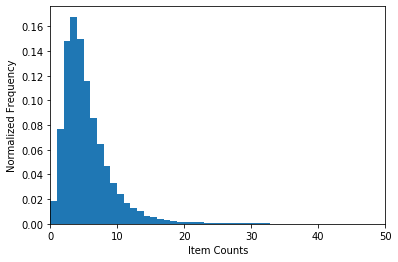

In [7]:
nbins = image_ids_sel['count'].max()+1
plt.xlim(0,50)
plt.xlabel('Item Counts')
plt.ylabel('Normalized Frequency')
count_hist = plt.hist(image_ids_sel['count'],bins=nbins,density=True)

## Item count analysis and label creation for ML

The analysis above shows that 75% of the bins have <= 6 items in them. The remaining 25% of the bins in the dataset have item counts > 6, up to 178. 

In this project, the goal is to identify the number of items in each image with a computer vision model. Since the dataset is dominated by objects with low item count, it will be difficult to train the model to recognize the most rare number counts. For this reason the labels for training will be defined in such a way that the problem will be simplified: 

- Count < 9: Label = Count 

- Count >= 9: Label = 9

This definition defines a supervised learning classification task with 10 classes.

In [8]:
image_ids_sel_wcount_wlabel_path = './image_ids_sel_wcount_wlabel.csv'
if not os.path.exists(image_ids_sel_wcount_wlabel_path):
    thr = 9
    image_ids_sel.loc[:,'label'] = image_ids_sel.loc[:,'count'].apply(lambda x: generate_labels(x,thr))
    image_ids_sel.to_csv(image_ids_sel_wcount_wlabel_path,index=False)
else:
    image_ids_sel = load_image_ids_sel(image_ids_sel_wcount_wlabel_path)

Loaded random subsample of 50000 images.


In [9]:
image_ids_sel

,id,count,label
0,1,12,9
1,14,1,1
2,17,10,9
3,30,6,6
4,31,3,3
...,...,...,...
49995,499920,8,8
49996,499932,5,5
49997,499938,6,6
49998,499978,6,6


## Analysis of the label distribution

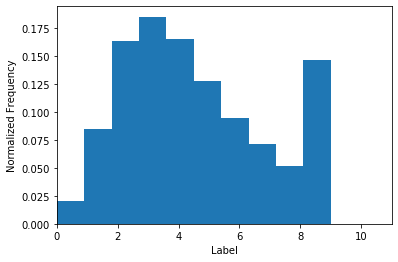

In [10]:
nbins = image_ids_sel['label'].max()+1
plt.xlim(0,11)
plt.xlabel('Label')
plt.ylabel('Normalized Frequency')
count_hist = plt.hist(image_ids_sel['label'],bins=nbins,density=True)

## Number of images by class label

As shown in the histogram above class balancing is not perfect, but each class receives > 900 examples (see below). 

In [11]:
image_ids_sel.groupby(by=['label']).agg('count')['id']

label
0     921
1    3829
2    7345
3    8343
4    7448
5    5757
6    4247
7    3198
8    2328
9    6584
Name: id, dtype: int64

## Visual image inspection

Image pre-processing will be included in the script that performs training. 

Here, we limit ourselves to inspect one of the images and verify that it can be retrieved from S3.

In [12]:
idd1 = 30 
idd2 = 499920
img1 = get_image(idd1)
img2 = get_image(idd2)

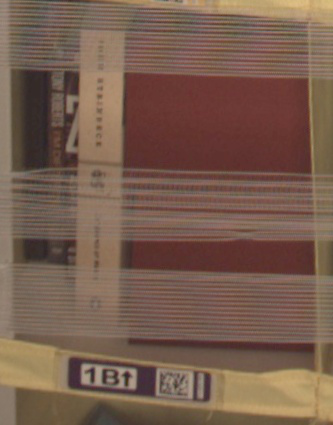

In [13]:
img1

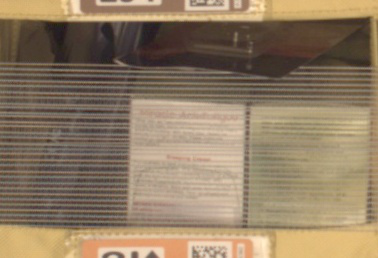

In [14]:
img2

### Counting the number of objects in these images is hard even for humans!




## Inspect image size

Image size is not fixed, it will need to be standardized before the model is applied.

In [15]:
img_data1 = np.asarray(img1)
img_data2 = np.asarray(img2)
print(f'Image {idd1} shape:',img_data1.shape)
print(f'Image {idd2} shape:',img_data2.shape)

Image 30 shape: (425, 333, 3)
Image 499920 shape: (258, 378, 3)


## Inspect pixel values

The images a JPEG with the usual RGB channels with pixel values from 0 to 255.

In [16]:
print(f'Image {idd1} min pixel value:',img_data1.min())
print(f'Image {idd1} max pixel value:',img_data1.max())
print(f'Image {idd2} min pixel value:',img_data2.min())
print(f'Image {idd2} max pixel value:',img_data2.max())

Image 30 min pixel value: 24
Image 30 max pixel value: 223
Image 499920 min pixel value: 12
Image 499920 max pixel value: 255


## Create train, validation, test split

Here we perform an 80:10:10 random split 

In [17]:
split = (0.8,0.1,0.1)
train_df,val_df,test_df = train_val_test_split(image_ids_sel,split)
train_df.to_csv('./train.csv',index=False)
val_df.to_csv('./validation.csv',index=False)
test_df.to_csv('./test.csv',index=False)

## Move definition of train, validation and test set to S3

In [18]:
!aws s3 cp ./train.csv s3://amazon-bin-images/

upload: ./train.csv to s3://amazon-bin-images/train.csv           


In [19]:
!aws s3 cp ./validation.csv s3://amazon-bin-images/

upload: ./validation.csv to s3://amazon-bin-images/validation.csv 


In [20]:
!aws s3 cp ./test.csv s3://amazon-bin-images/

upload: ./test.csv to s3://amazon-bin-images/test.csv             
